<img src="./image/IBM.jpg" width="100%">

# Recommendations with IBM

In this notebook, I will be putting my recommendation skills to use on real data from the IBM Watson Studio platform. 

By following the table of contents, I will build out a number of different methods for making recommendations that you can follow it. 

***


## Table of Contents

0. [Loading Libraries - Loading and Inspection of Datasets](#Loading)
1. [Exploratory Data Analysis](#Exploratory-Data-Analysis)
2. [Rank Based Recommendations](#Rank)
3. [User-User Based Collaborative Filtering](#User-User)
4. [Content Based Recommendations (EXTRA - NOT REQUIRED)](#Content-Recs)
5. [Matrix Factorization](#Matrix-Fact)
6. [Extras & Concluding](#conclusions)

Let's get started by importing the necessary libraries and reading in the data.

### <a class="anchor" id="Loading">Part 0: Loading Libraries - Loading and Inspection of Datasets</a>
#### 0.1. Loading of Libraries

In [1]:
# Loading Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import project_tests as t
import pickle

from nltk.tokenize import word_tokenize
import nltk
from nltk.tokenize import word_tokenize
from nltk import WordNetLemmatizer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from nltk.corpus import stopwords
#import time
import re

nltk.download('wordnet')
nltk.download('stopwords')

%matplotlib inline

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### 0.2.Loading and Inspection of Data

In [2]:
# Loading Datasets
"""
df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
"""

#url = 'D:/DS_Document/Data_UdaCity/DSND_Term2-master/project_files/Recommendations_with_IBM/data/'
url = './data/'
path_user_item = url +'user-item-interactions.csv'
df = pd.read_csv(path_user_item)


path_articles = url +'articles_community.csv'
df_content = pd.read_csv(path_articles)


del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45993 entries, 0 to 45992
Data columns (total 3 columns):
article_id    45993 non-null float64
title         45993 non-null object
email         45976 non-null object
dtypes: float64(1), object(2)
memory usage: 1.1+ MB


In [4]:
# The number of records
df.shape[0]

45993

In [5]:
# Describe of dataframe of df 

# percentile list 
perc =[.15, .25,  .30, .50, .75, .90] 
  
# list of dtypes to include 
include =['object', 'float', 'int'] 

df[['article_id']].describe(percentiles = perc, include = include)

,article_id
count,45993.000000
mean,908.846477
std,486.647866
min,0.000000
15%,210.000000
25%,460.000000
30%,616.000000
50%,1151.000000
75%,1336.000000
90%,1423.000000


In [6]:
#The number of Unique of features
display(df_content.nunique())

display(df.nunique())


doc_body           1036
doc_description    1022
doc_full_name      1051
doc_status            1
article_id         1051
dtype: int64

article_id     714
title          714
email         5148
dtype: int64

In [7]:
df_content.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1056 entries, 0 to 1055
Data columns (total 5 columns):
doc_body           1042 non-null object
doc_description    1053 non-null object
doc_full_name      1056 non-null object
doc_status         1056 non-null object
article_id         1056 non-null int64
dtypes: int64(1), object(4)
memory usage: 41.3+ KB


In [8]:
# The number of records
df_content.shape[0]

1056

In [9]:
# Describe of dataframe of df 
df_content[['article_id']].describe(percentiles = perc)

,article_id
count,1056.000000
mean,523.913826
std,303.480641
min,0.000000
15%,157.250000
25%,260.750000
30%,313.500000
50%,523.500000
75%,786.250000
90%,944.500000


In [10]:
df.sort_values(by = 'article_id', ascending = False).head()

,article_id,title,email
21382,1444.0,worldwide fuel oil consumption by household (i...,d313c83ab3ed388ba16042a6cd33fce57d6a9e9a
27402,1444.0,worldwide fuel oil consumption by household (i...,c45f9495a76bf95d2633444817f1be8205ad542d
30249,1444.0,worldwide fuel oil consumption by household (i...,6cce7568da5452718e1a3702edffac34a8da74ec
17095,1444.0,worldwide fuel oil consumption by household (i...,d5843ed71361c87b364f578f20a48101289d60f9
2374,1444.0,worldwide fuel oil consumption by household (i...,fd824fc62b4753107e3db7704cd9e8a4a1c961f1


In [11]:
# Show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

**`1.1.`** What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

In [12]:
# The number of articles read by each users
df[['email','article_id']].groupby(['email']).count().sort_values(by= 'article_id',ascending=False)

,article_id
email,
2b6c0f514c2f2b04ad3c4583407dccd0810469ee,364
77959baaa9895a7e2bdc9297f8b27c1b6f2cb52a,363
2f5c7feae533ce046f2cb16fb3a29fe00528ed66,170
a37adec71b667b297ed2440a9ff7dad427c7ac85,169
8510a5010a5d4c89f5b07baac6de80cd12cfaf93,160
f8c978bcf2ae2fb8885814a9b85ffef2f54c3c76,158
284d0c17905de71e209b376e3309c0b08134f7e2,148
18e7255ee311d4bd78f5993a9f09538e459e3fcc,147
d9032ff68d0fd45dfd18c0c5f7324619bb55362c,147


In [13]:
# 50% of individuals interact with '3' number of articles or fewer.
median_val = df.email.value_counts().median() 
print('50% of individuals interact with {} number of articles or fewer'.format(median_val))

50% of individuals interact with 3.0 number of articles or fewer


In [14]:
# The maximum number of user-article interactions
max_views_by_user = df.email.value_counts()[0]
print('The maximum number of user-article interactions by any 1 user is {}'.format(max_views_by_user))

The maximum number of user-article interactions by any 1 user is 364


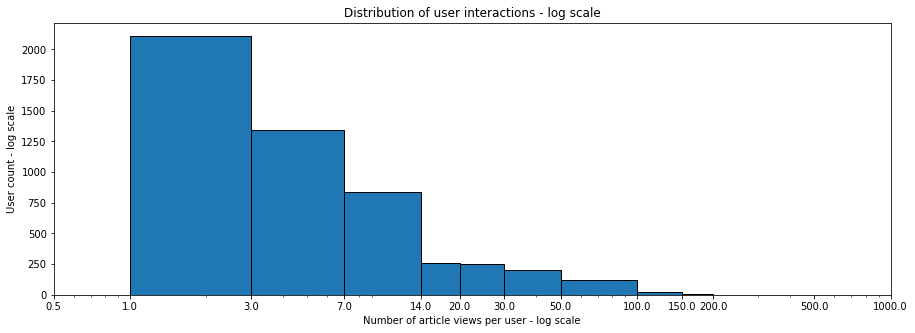

In [15]:
hist_bins = [0,1,3,7,14,20,30,50,100,150,200,500]
hist_ticks = np.array([0.5, 1,3,7,14,20,30,50,100,150,200,500,1000])
plt.figure(figsize=(15,5))
plt.hist(df[['email','article_id']].groupby(['email']).count()['article_id'],bins=hist_bins,histtype='bar',ec='black')
plt.yscale('linear')
plt.xscale('log')
plt.xticks(hist_ticks,hist_ticks.astype(str))
plt.title('Distribution of user interactions - log scale')
plt.xlabel('Number of article views per user - log scale')
plt.ylabel('User count - log scale')
plt.show()

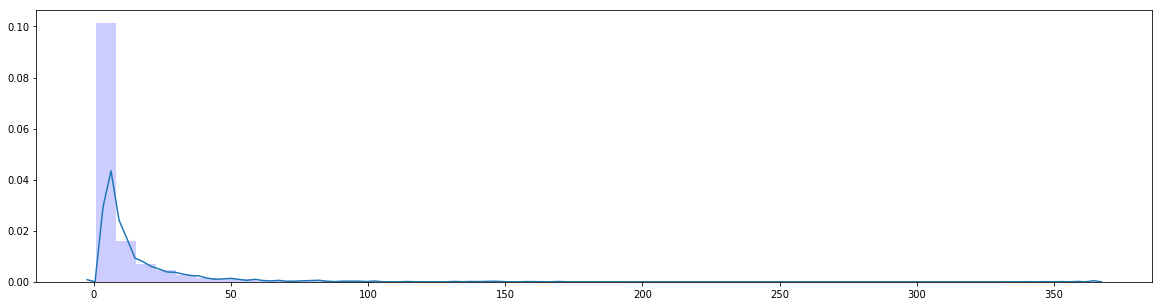

In [17]:
plt.figure(figsize=(20,5))
sns.distplot(df.groupby('email')['article_id'].count().values, hist_kws={"alpha": 0.2, "color": "b"});

**`1.2.`** Explore and remove duplicate articles from the **df_content** dataframe.  

In [18]:
# Find and explore duplicate articles
# First look
print('Duplicated inputs as rows :',df_content.duplicated().any().sum() )

Duplicated inputs as rows : 0


In [19]:
# Investigation of row of Duplicate by 'article_id'
df_content.groupby(['article_id','doc_full_name'])['doc_full_name'].count().sort_values(ascending=False).head(10)

article_id  doc_full_name                                                                               
221         How smart catalogs can turn the big data flood into an ocean of opportunity                     2
232         Self-service data preparation with IBM Data Refinery                                            2
577         Use the Primary Index                                                                           2
398         Using Apache Spark as a parallel processing framework for accessing REST based data services    2
50          Graph-based machine learning                                                                    2
356         Deep Learning, Structure and Innate Priors                                                      1
355         Run Shiny Applications in RStudio in DSX                                                        1
354         Build the search index in Cloudant                                                              1
353         spa

We found **duplicated 5 records**. _We should remove_ these and only keep the first of dublicated records.

In [20]:
# As we can see from below info, there are 5 Articles that duplicated 
print('Shape of df_content is',df_content.shape[0])
print()
print(df_content.nunique())

Shape of df_content is 1056

doc_body           1036
doc_description    1022
doc_full_name      1051
doc_status            1
article_id         1051
dtype: int64


In [21]:
# Dropping dublicate rows by 'article_id'
print('(Before dropping) The number of record :',df_content.shape[0])
df_content = df_content.drop_duplicates(subset='article_id', keep='first')
print('(After dropping) The number of record :',df_content.shape[0])

(Before dropping) The number of record : 1056
(After dropping) The number of record : 1051


**`1.3.`** Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

**`1.3.a.`** The number of unique articles that have an interaction with a user.

In [22]:
unique_articles = df.article_id.nunique()
print("The number of 'unique articles' is {}".format(unique_articles))

The number of 'unique articles' is 714


**`1.3.b.`** The number of unique articles in the dataset (whether they have any **_interactions or not_**).

In [23]:
total_articles = df_content.article_id.nunique()
print("The number of 'total articles' is {}".format(total_articles))

The number of 'total articles' is 1051


**`1.3.c.`** The number of **unique users** in the dataset. (excluding null values)

In [24]:
unique_users = df.email.nunique()
print("The number of 'unique users' are {}".format(unique_users))

The number of 'unique users' are 5148


In [25]:
df.email.isnull().sum()

17

In [26]:
# We researche Null value inside feature of 'email'
#df.groupby('email').count().sort_values('article_id', ascending=False).iloc[677:715]

**`1.3.d.`** The number of **user-article interactions** in the dataset.

In [27]:
user_article_interactions = df.shape[0]
print('The number of user-article interactions is {}'.format(user_article_interactions))

The number of user-article interactions is 45993


**`1.4.`** Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [28]:
# The most viewed article in the dataset as a string with one value following the decimal 
most_viewed_article_id = df.article_id.value_counts().index[0]

# The most viewed article in the dataset was viewed how many times?
max_views = df.article_id.value_counts().values[0]

In [29]:
print('The most viewed article in the dataset is {}'.format(most_viewed_article_id))
print()
print('The most viewed article in the dataset is {}'.format(max_views))
print()
print('Most viewed article_id is {}, and viewed as {} many times'.format(int(most_viewed_article_id),max_views))

The most viewed article in the dataset is 1429.0

The most viewed article in the dataset is 937

Most viewed article_id is 1429, and viewed as 937 many times


In [30]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [31]:
user_article_interactions

45993

In [32]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': str(most_viewed_article_id),
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

**`2.1.`** Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [33]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    
    top_articles = df.title.value_counts(sort=True).index[:n].values
        
    return top_articles # Return the top article titles from df (not df_content)

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles_ids - (list) A list of ids of the top 'n' article titles 
    
    '''

    top_articles_ids = df.article_id.value_counts(sort=True).index[:n].values
 
    return top_articles_ids # Return the top article ids

In [34]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['use deep learning for image classification'
 'insights from new york car accident reports'
 'visualize car data with brunel'
 'use xgboost, scikit-learn & ibm watson machine learning apis'
 'predicting churn with the spss random tree algorithm'
 'healthcare python streaming application demo'
 'finding optimal locations of new store using decision optimization'
 'apache spark lab, part 1: basic concepts'
 'analyze energy consumption in buildings'
 'gosales transactions for logistic regression model']
[ 1429.  1330.  1431.  1427.  1364.  1314.  1293.  1170.  1162.  1304.]


In [35]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


**`3.1.`** Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [36]:
def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    # Create list of User_id
    user_index = list(df.user_id.unique())
    artic_col = list(df.article_id.unique());artic_col.sort()
    
    # Create User-Item Matrix with Zeros
    user_item = pd.DataFrame(np.zeros((len(user_index),len(artic_col))), index=user_index, columns=artic_col)
    
    # Create dictionary of Article_id and Article_Index
    dic = dict()
    for i in user_index:
        dic[i] = list(df[df.user_id==i]['article_id'].values)
    
    # Filling User-Item Matrix
    for i in user_index:
        for j in artic_col:
            if j in dic[i]:
                user_item.loc[i,j]=1
    return user_item

user_item = create_user_item_matrix(df)

In [37]:
# Contraller
print('1:',user_item.sum(axis=1)[1])
print('2:',user_item.sum(axis=1)[2])
print('3:',user_item.sum(axis=1)[3])
print('5145:',user_item.sum(axis=1)[5145])
print('5149:',user_item.sum(axis=1)[5146])
print('5147:',user_item.sum(axis=1)[5147])
print('5148:',user_item.sum(axis=1)[5148])
print('5149:',user_item.sum(axis=1)[5149])

1: 36.0
2: 6.0
3: 40.0
5145: 5.0
5149: 7.0
5147: 1.0
5148: 1.0
5149: 1.0


In [38]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


**`3.2.`** Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [39]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    # compute similarity of each user to the provided user
    user_sim = user_item[user_item.index == user_id].dot(user_item.T)
    
    # sort by similarity
    user_sim.sort_values(by=user_id,axis=1,ascending=False, inplace=True)
    
    # create list of just the ids
    most_similar_users = user_sim.columns.values.tolist()
    
    # remove the own user's id
    most_similar_users.remove(user_id)
       
    return most_similar_users # return a list of the users in order from most to least similar
        

In [40]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 3870, 131, 4201, 46, 5041]
The 5 most similar users to user 3933 are: [1, 23, 3782, 203, 4459]
The 3 most similar users to user 46 are: [4201, 3782, 23]


**`3.3.`** Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [41]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    
    article_names = df['title'][df['article_id'].isin(article_ids)].unique().tolist()
        
    return article_names # Return the article names associated with list of article ids


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    
    
    article_ids = df[df.user_id==user_id]['article_id'].unique()
    article_ids = article_ids.astype(str).tolist()
    article_names = get_article_names(article_ids, df=df)
    return article_ids, article_names # return the ids and names


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    
    most_similar_users = find_similar_users(user_id, user_item=user_item)
   
    u_articleid = get_user_articles(user_id, user_item=user_item)[0]
    
    recs= []
    for user in most_similar_users:
        if len(recs) <= m:
            g_articleid, g_article_title= get_user_articles(user, user_item=user_item)
            new_rec = np.setdiff1d(g_articleid, u_articleid, assume_unique=True)
            recs.append(new_rec)
            recs = [x for sub in recs for x in sub]
        else:
            break

    recs = recs[:m]
   
    return recs # return your recommendations for this user_id    

In [42]:
# Check Results
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

['got zip code data? prep it for analytics. – ibm watson data lab – medium',
 'the unit commitment problem',
 'dsx: hybrid mode',
 'gosales transactions for logistic regression model',
 'using github for project control in dsx',
 'accelerate your workflow with dsx',
 'data visualization playbook: telling the data story',
 'experience iot with coursera',
 'shaping data with ibm data refinery',
 'programmatic evaluation using watson conversation']

In [43]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


In [44]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
   
    user_user = user_item.dot(user_item.T)
    len_user = df.user_id.value_counts().sort_index().values
    user_user['len_user'] = len_user
    neighbors_df = user_user[[user_id, 'len_user']].sort_values(by=[user_id, 'len_user'], ascending=False)
    neighbors_df.reset_index(inplace=True)
    neighbors_df.rename(columns={'index':'neighbor_id', user_id :'similarity', 'len_user':'num_interactions'}, inplace=True)
       
    return neighbors_df # Return the dataframe specified in the doc_string

**`3.4.`** Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [45]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
   
    user_user = user_item.dot(user_item.T)
    len_user = df.user_id.value_counts().sort_index().values
    user_user['len_user'] = len_user
    neighbors_df = user_user[[user_id, 'len_user']].sort_values(by=[user_id, 'len_user'], ascending=False)
    neighbors_df.reset_index(inplace=True)
    neighbors_df.rename(columns={'index':'neighbor_id', user_id :'similarity', 'len_user':'num_interactions'}, inplace=True)
       
    return neighbors_df # Return the dataframe specified in the doc_string


def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    neighbor = get_top_sorted_users(user_id, df=df, user_item=user_item)['neighbor_id'].values.tolist()

    recs = []
    rec_names = []
    for user in neighbor:
        if len(recs) < 10:
            article_ids = get_user_articles(user)[0]
            article_names = get_user_articles(user)[1]
            for i,j in zip(article_ids, article_names):
                recs.append(i)
                rec_names.append(j)
        else:
            break
    
    return recs[:m], rec_names[:m]

In [46]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
['1320.0', '844.0', '232.0', '164.0', '109.0', '362.0', '1427.0', '1338.0', '880.0', '981.0']

The top 10 recommendations for user 20 are the following article names:
['housing (2015): united states demographic measures', 'use the cloudant-spark connector in python notebook', 'self-service data preparation with ibm data refinery', 'ml optimization using cognitive assistant', 'deploy your python model as a restful api', 'apache spark lab, part 1: basic concepts', 'timeseries data analysis of iot events by using jupyter notebook', 'dsx: hybrid mode', 'predicting churn with the spss random tree algorithm', 'analyze energy consumption in buildings']


**`3.5.`** Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [47]:
### Tests with a dictionary of results

# Find the user that is most similar to user 1 
user1_most_sim = get_top_sorted_users(1, df=df, user_item=user_item)['neighbor_id'].values.tolist()[1]

# Find the 10th most similar user to user 131
user131_10th_sim = get_top_sorted_users(131, df=df, user_item=user_item)['neighbor_id'].values.tolist()[10]

In [48]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


**`3.6.`** If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?

_**<blockquote>Explanation for Question 6 <br></blockquote>**_
_<blockquote>New user, new customer, new article means that there is no data available. That problem is called Cold Start Problem. For the cases like that, we can use Popular (Knowledge) Based filtering methods for that problems.</blockquote>_

**`3.7.`** Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [49]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 
 
new_user_recs = get_top_article_ids(10) 
new_user_recs = [str(i) for i in new_user_recs] 
new_user_recs

['1429.0',
 '1330.0',
 '1431.0',
 '1427.0',
 '1364.0',
 '1314.0',
 '1293.0',
 '1170.0',
 '1162.0',
 '1304.0']

In [50]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Content-Recs">Part IV: Content Based Recommendations (EXTRA - NOT REQUIRED)</a>

Another method we might use to make recommendations is to perform a ranking of the highest ranked articles associated with some term.  You might consider content to be the **doc_body**, **doc_description**, or **doc_full_name**.  There isn't one way to create a content based recommendation, especially considering that each of these columns hold content related information.  

`1.` Use the function body below to create a content based recommender.  Since there isn't one right answer for this recommendation tactic, no test functions are provided.  Feel free to change the function inputs if you decide you want to try a method that requires more input values.  The input values are currently set with one idea in mind that you may use to make content based recommendations.  One additional idea is that you might want to choose the most popular recommendations that meet your 'content criteria', but again, there is a lot of flexibility in how you might make these recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [ ]:
df_content.head()

In [ ]:
print(df_content.doc_body.nunique())
print(df_content.doc_description.nunique())
print(df_content.doc_full_name.nunique())
print(df_content.shape)

### make a recommendations for a user who has only interacted with article id '1427.0'

There is no content info about article 1427 in "df_column". However from "df", I can find other 643 users' interaction with this article. These 643 users can be considered to be "neighbors" of this new user.

I will focus on article ids these users read aside from 1427. It should make sense that more an article is read by more neighbors, the better the article should be recommended.



### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

**`5.1.`** You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [51]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [52]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**`5.2.`** In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD, and explain why this is different than in the lesson.

In [53]:
u, s, vt = np.linalg.svd(user_item_matrix)
print(u.shape)
print(s.shape)
print(vt.shape)

(5149, 5149)
(714,)
(714, 714)


_**<blockquote>Explanation for Question 5.2 <br></blockquote>**_
<blockquote>This  time data is a lot larger and  we did not emphasize the shape of data this time but in lesson it was given as (20,4)<br>
Also during the lesson, User-Item Matrix contained null values in it and SVD does not work with null values. We used Funk SVD in the lesson to solve this issue. In this case, the matrix does not have any null value that means we can use SVD method.<br></blockquote>

**`5.3.`** Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

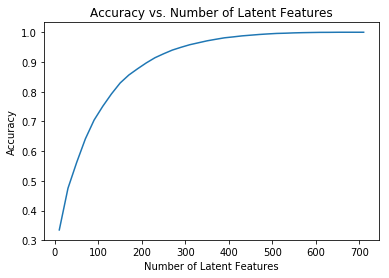

In [54]:
num_latent_feats = np.arange(10,714,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

**`5.4.`** From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

In [55]:
df_train = df.head(40000)
df_test = df.tail(5993)
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [56]:
create_user_item_matrix(df_train).head()

,0.0,2.0,4.0,8.0,9.0,12.0,14.0,15.0,16.0,18.0,...,1434.0,1435.0,1436.0,1437.0,1439.0,1440.0,1441.0,1442.0,1443.0,1444.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [57]:
create_user_item_matrix(df_test).head()

,0.0,2.0,4.0,8.0,9.0,12.0,14.0,15.0,16.0,18.0,...,1432.0,1433.0,1434.0,1435.0,1436.0,1437.0,1439.0,1440.0,1441.0,1443.0
4487,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4488,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4489,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4490,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4491,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [58]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''

    # Find user-item matrix for train and test
    user_item_train = create_user_item_matrix(df_train)
    user_item_test = create_user_item_matrix(df_test)
    
    # Find user idx and article of train set
    train_idx = set(user_item_train.index)
    train_arts = set(user_item_train.columns)

    # Find user idx and article of test set
    test_idx = set(user_item_test.index)
    test_arts =  set(user_item_test.columns)
        
    # Intersection user idx and article with train and test sets
    common_idx = list(train_idx.intersection(test_idx))
    common_cols = list(train_arts.intersection(test_arts))

    #
    user_item_test = user_item_test.loc[common_idx, common_cols]
    
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [59]:
print('articles of the test set we can make predictions about')
print(len(np.intersect1d(df_train.article_id.unique(),df_test.article_id.unique())))

print('articles of the test set we cant make predictions about')
print(len(df_test.article_id.unique()) - len(np.intersect1d(df_train.article_id.unique(),df_test.article_id.unique())))

print('users of the test set we can make predictions about')
print(len(np.intersect1d(df_train.user_id.unique(),df_test.user_id.unique())))

print('users of the test set we cant make predictions about')
print(len(df_test.user_id.unique()) - len(np.intersect1d(df_train.user_id.unique(),df_test.user_id.unique())))

articles of the test set we can make predictions about
574
articles of the test set we cant make predictions about
0
users of the test set we can make predictions about
20
users of the test set we cant make predictions about
662


In [60]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 


sol_4_dict = {
    'How many users can we make predictions for in the test set?': c, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a, 
    'How many movies can we make predictions for in the test set?': b,
    'How many movies in the test set are we not able to make predictions for because of the cold start problem?': d
}

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test movies are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


**`5.5.`** Now use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

#### MODEL TRAINING and TESTING

In [61]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train) # fit svd similar to above then use the cells below

print(u_train.shape)
print(s_train.shape)
print(vt_train.shape)

(4487, 4487)
(714,)
(714, 714)


In [62]:
row_idxs = user_item_train.index.isin(test_idx)
col_idxs = user_item_train.columns.isin(test_arts)
u_test = u_train[row_idxs, :]
vt_test = vt_train[:, col_idxs]

In [63]:
# Use these cells to see how well you can use the training decomposition to predict on test data

num_latent_feats = np.arange(0,714,30)
sum_errs_train = []
sum_errs_test = []
all_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_train_lat, u_train_lat, vt_train_lat = np.diag(s_train[:k]), u_train[:, :k], vt_train[:k, :]
    u_test_lat, vt_test_lat = u_test[:, :k], vt_test[:k, :]
    
    # take dot product
    user_item_train_preds = np.around(np.dot(np.dot(u_train_lat, s_train_lat), vt_train_lat))
    user_item_test_preds = np.around(np.dot(np.dot(u_test_lat, s_train_lat), vt_test_lat))
    all_errs.append(1 - ((np.sum(user_item_test_preds)+np.sum(np.sum(user_item_test)))/(user_item_test.shape[0]*user_item_test.shape[1])))
    
    
    # compute error for each prediction to actual value
    diffs_train = np.subtract(user_item_train, user_item_train_preds)
    diffs_test = np.subtract(user_item_test, user_item_test_preds)
    
    # total errors and keep track of them
    err_train = np.sum(np.sum(np.abs(diffs_train)))
    err_test = np.sum(np.sum(np.abs(diffs_test)))
    
    sum_errs_train.append(err_train)
    sum_errs_test.append(err_test)


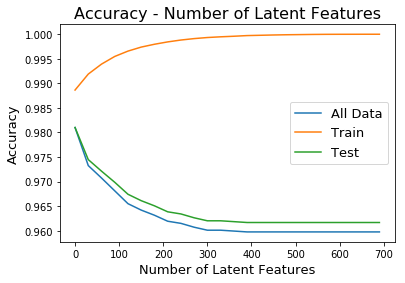

In [64]:
plt.plot(num_latent_feats, all_errs, label='All Data');
plt.plot(num_latent_feats, 1 - np.array(sum_errs_train)/(user_item_train.shape[0]*user_item_test.shape[1]), label='Train');
plt.plot(num_latent_feats, 1 - np.array(sum_errs_test)/(user_item_test.shape[0]*user_item_test.shape[1]), label='Test');

plt.xlabel('Number of Latent Features', fontsize= 13);
plt.ylabel('Accuracy', fontsize= 13);
plt.title('Accuracy - Number of Latent Features', fontsize= 16);
plt.legend(fontsize= 13);

**`5.6.`** Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles? 

In [65]:
print('users of the test set we can make predictions about')
print(len(np.intersect1d(df_train.user_id.unique(),df_test.user_id.unique())))

users of the test set we can make predictions about
20


> ## **Result and Interpretation of the Model**<br>
> Overall, the accuracy is very high across all sets for any number of **latent** features. <br>
In this training set, accuracy logarithmically increases as the number of latent features increases in the training set. It peaks at nearly **`99.9%`** accuracy and troughs at **`98.5%`** accurracy.<br>
Also, in this testing set and whole set, accuracy logarithmically decreases as the number of latent features increases. It peaks at **`98.2%`** accuracy and troughs at **`96.1%`** accuracy.<br>
> Besides of that, the accuracy is reported to be very high and it is important to verify the results in different ways. Since the dataset is inbalanced it might be interesting to explore undersampling techniques to see if that improves results.<br>
> * Unfortunately  we have too less users of the test set(**` 20 `**) we can make **predictions about records** in the training and testing datasets, result will not satisfy our questions/search to see how good predictions are done through SVD.
> * Even if results and plots show us great result, in fact we cant claim it is true because there is imbalanced data problem.
> * Recommendation Engines are great to solve problems but as like most of the method it  also has weakness for the  offline methods. There is  one appropriate way like _**Experimental Design - A/B Test approach**_ is a solid procedure to understand if the model brings real benefits.
> * Basic **A/B Test** approach for this situation could be to _assign %50 of users to a control group with no recommendations and another group with recommendations_. After settting up A/B Test approach we will  be understanding whether the recommendation system increases the number of user-article interactions).


<a id='conclusions'></a>
### Extras
Using your workbook, you could now save your recommendations for each user, develop a class to make new predictions and update your results, and make a flask app to deploy your results.  These tasks are beyond what is required for this project.  However, from what you learned in the lessons, you certainly capable of taking these tasks on to improve upon your work here!


## Conclusion

> Congratulations!  You have reached the end of the Recommendations with IBM project! 

> **Tip**: Once you are satisfied with your work here, check over your report to make sure that it is satisfies all the areas of the [rubric](https://review.udacity.com/#!/rubrics/2322/view). You should also probably remove all of the "Tips" like this one so that the presentation is as polished as possible.


## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations! 

In [66]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb'])

0